In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
    
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [105]:
# heat_df1 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.05.02-05.08.csv", encoding="euc-kr")
# heat_df2 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.05.09-05.15.csv", encoding="euc-kr")
# heat_df3 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.05.16-05.22.csv", encoding="euc-kr")
# heat_df4 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.05.23-05.29.csv", encoding="euc-kr")
# heat_df5 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.05.30-06.05.csv", encoding="euc-kr")
# heat_df6 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.06.06-06.12.csv", encoding="euc-kr")
# heat_df7 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.06.13-06.19.csv", encoding="euc-kr")
# heat_df8 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.06.20-06.26.csv", encoding="euc-kr")
# heat_df9 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.06.27-07.03.csv", encoding="euc-kr")
# heat_df10 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.07.04-07.10.csv", encoding="euc-kr")
# heat_df11 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.07.11-07.17.csv", encoding="euc-kr")
# heat_df12 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.07.18-07.24.csv", encoding="euc-kr")
# heat_df13 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.07.25-07.31.csv", encoding="euc-kr")
# heat_df14 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.08.01-08.07.csv", encoding="euc-kr")
# heat_df15 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.08.08-08.14.csv", encoding="euc-kr")
# heat_df16 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.08.15-08.21.csv", encoding="euc-kr")
# heat_df17 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.08.22-08.28.csv", encoding="euc-kr")
# heat_df18 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.08.29-09.04.csv", encoding="euc-kr")
# heat_df19 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.09.05-09.11.csv", encoding="euc-kr")
# heat_df20 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.09.12-09.18.csv", encoding="euc-kr")
# heat_df21 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.09.19-09.25.csv", encoding="euc-kr")
# heat_df22 = pd.read_csv("./data/폭염/S-DoT_NATURE_2022.09.26-10.02.csv", encoding="euc-kr")

# heat_df = pd.concat([heat_df1, heat_df2, heat_df3, heat_df4, heat_df5, heat_df6, heat_df7, heat_df8, heat_df9, heat_df10, heat_df11, heat_df12, heat_df13, heat_df14, heat_df15, heat_df16, heat_df17, heat_df18, heat_df19, heat_df20, heat_df21, heat_df22], ignore_index=True)

# heat_df.columns = heat_df.columns.str.strip()

path = "./data/폭염/S-DoT_NATURE_2022*.csv"

files = glob.glob(path)

df_list = [pd.read_csv(f, encoding='euc-kr') for f in files]

heat_df = pd.concat(df_list, ignore_index=True)

# 서울시 데이터만 필터링
heat_df = heat_df[heat_df['기관 명'] == '서울시']

# 컬럼명 공백 제거
heat_df.columns = heat_df.columns.str.strip()

# 필요한 컬럼만 추출
use_cols = ['기관 명', '등록일자', '기온(℃)']

heat_df = heat_df[use_cols]

# 컬럼명 영어로 변경
heat_df.columns = ['agency', 'datetime', 'temp']

# 일시->날짜로 컬럼 추가
heat_df['datetime'] = pd.to_datetime(heat_df['datetime'])
heat_df['date'] = heat_df['datetime'].dt.date

In [106]:
# 이상치 제거
# 대한민국 기상 관측 이래 가장 높은 최고기온 기록은 41.0℃
heat_df = heat_df[(heat_df['temp'] >= 0) & (heat_df['temp'] <= 41)]
print(heat_df['temp'].min())
print(heat_df['temp'].max())
print(heat_df['temp'].mean())
# 일별 최고기온 계산
daily_max = heat_df.groupby('date')['temp'].max().reset_index()
heat_df = daily_max[(daily_max['temp'] >= 33) & (daily_max['temp'] <= 41)] # 폭염일 기준 온도 33도 이상, 41도 이하

0.0
41.0
24.89800594752758


In [ ]:
# 미세먼지 데이터
dust_df = pd.read_csv("./data/미세먼지/서울시 대기질 자료 제공_2022.csv", encoding="euc-kr")
dust_df.columns = dust_df.columns.str.strip()

 # 구 단위로 되어 있는거 빼고 평균만 잡기
dust_df = dust_df[dust_df['구분'] == '평균']

dust_df['일시'] = pd.to_datetime(dust_df['일시'])
dust_df['date'] = dust_df['일시'].dt.date
dust_df = (
    dust_df.groupby('date')[['미세먼지(PM10)', '초미세먼지(PM2.5)']].mean().reset_index()
)
dust_df.columns = ['date', 'pm10', 'pm25']
dust_df

,date,pm10,pm25
0,2022-01-01,27.250000,14.708333
1,2022-01-02,34.750000,23.333333
2,2022-01-03,25.291667,14.791667
3,2022-01-04,33.833333,19.541667
4,2022-01-05,47.833333,29.375000
...,...,...,...
360,2022-12-27,49.208333,36.541667
361,2022-12-28,34.500000,21.250000
362,2022-12-29,30.291667,18.375000
363,2022-12-30,38.416667,27.625000


In [108]:
# 폭염 미세먼지 데이터 병합
heat_dust = pd.merge(
    heat_df,
    dust_df
)
heat_dust

,date,temp,pm10,pm25
0,2022-05-09,37.8,15.000000,6.625000
1,2022-05-10,34.2,24.000000,12.208333
2,2022-05-12,34.5,31.083333,14.041667
3,2022-05-25,34.4,24.208333,12.583333
4,2022-05-28,34.8,33.000000,18.125000
...,...,...,...,...
89,2022-09-27,38.5,25.333333,13.708333
90,2022-09-28,33.5,29.708333,17.000000
91,2022-09-29,35.4,57.958333,42.041667
92,2022-09-30,35.9,49.041667,34.791667


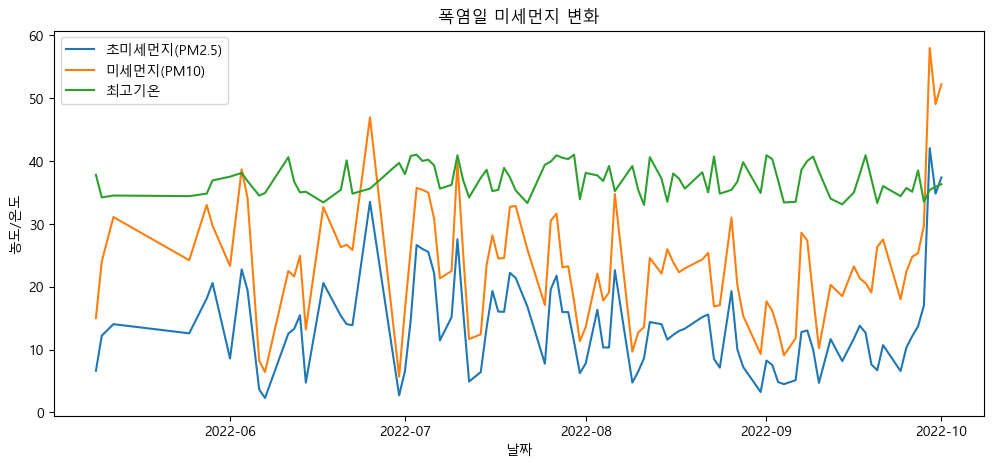

In [109]:
heat_dust = heat_dust.sort_values('date')

plot_df = heat_dust.dropna(subset=['pm25', 'pm10', 'temp'])
plt.figure(figsize=(12,5))
plt.plot(plot_df['date'], plot_df['pm25'], label='초미세먼지(PM2.5)')
plt.plot(plot_df['date'], plot_df['pm10'], label='미세먼지(PM10)')
plt.plot(plot_df['date'], plot_df['temp'], label='최고기온')
plt.title('폭염일 미세먼지 변화')
plt.xlabel('날짜')
plt.ylabel('농도/온도')
plt.legend()
plt.show()